# Modeling-to-Generate-Alternatives (MGA) Tutorial

MGA is commonly used in energy modelling to address what is known as "structural uncertainty."
That is, the uncertainty stemming from unknown, unmodeled, or unmodel-able objectives. For instance,
political feasibility or some other qualitative variable.

## The MGA Idea

To get around this challenge, MGA searches the "sub-optimal" or "near-optimal" region for alternative
solutions by relaxing the objective function. The goal for a single-objective problem is to find 
"maximally different solutions in the design space." In multi-objective problems, specifically ones solved
with genetic algorithms, users can identify alternatives by random selection or farthest first traversal.

This tutorial will illustrate both methods.

## MGA Example \#1

In [253]:
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools as it
# pymoo imports
from pymoo.problems import get_problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize

from osier import n_mga
from osier.utils import *

In [254]:
problem = get_problem("bnh")

pop_size = 100
n_gen = 200
algorithm = NSGA2(pop_size=pop_size)

res = minimize(problem,
               algorithm,
               ('n_gen', n_gen),
               seed=1,
               verbose=False,
               save_history=True
               )


In [255]:
F = problem.pareto_front()
a = min(F[:,0])
b = max(F[:,0])
f1 = F[:,0]
f2 = F[:,1]
shift = 0.75
slack = 0.2
alpha = 0.5
F1 = f1 * (1+slack)
F2 = f2 * (1+slack)

In [256]:
X_hist = np.array([history.pop.get("X") for history in res.history]).reshape(n_gen*pop_size,2)
F_hist = np.array([history.pop.get("F") for history in res.history]).reshape(n_gen*pop_size,2)

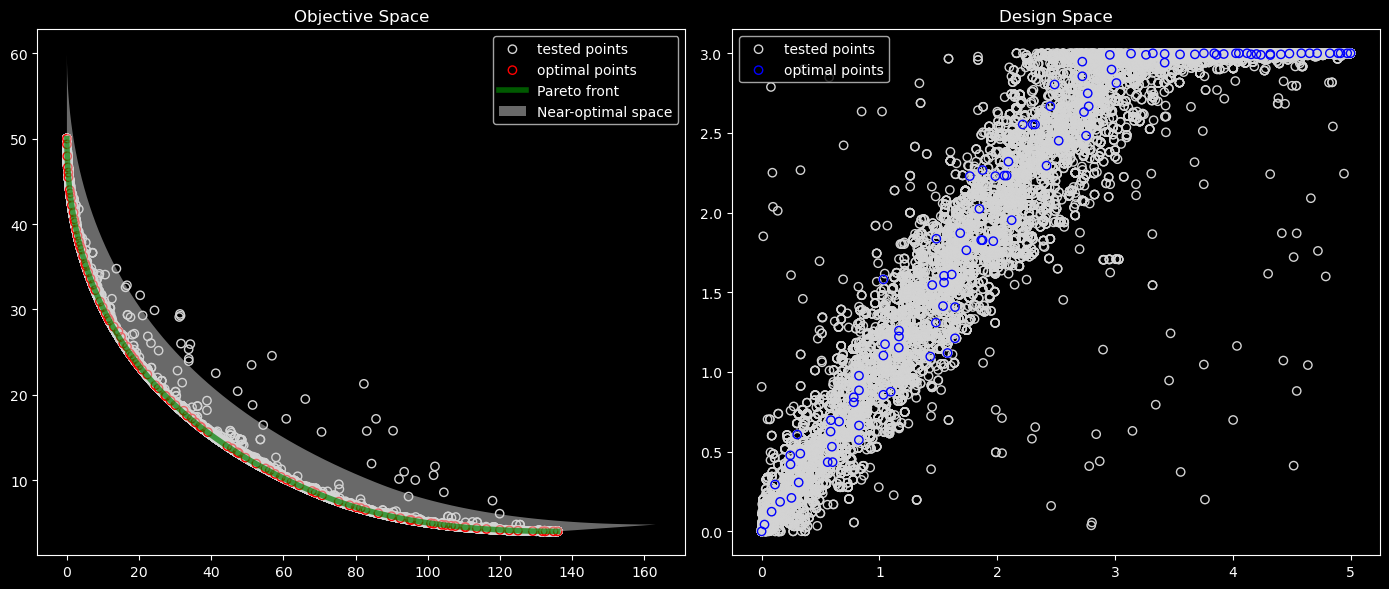

In [257]:
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(1,2, figsize=(14,6))

    ax[0].set_title("Objective Space")
    ax[0].scatter(F_hist[:,0], F_hist[:,1], facecolor="none", edgecolor="lightgray", label='tested points')
    ax[0].scatter(res.F[:,0], res.F[:,1], facecolor="none", edgecolor="red", label='optimal points')
    ax[0].plot(F[:,0], F[:,1], color="g", alpha=0.7, label='Pareto front', lw=4)
    ax[0].fill(np.append(f1, F1[::-1]), np.append(f2, F2[::-1]), 'lightgrey', alpha=alpha, label="Near-optimal space")
    ax[0].legend()


    ax[1].set_title("Design Space")
    ax[1].scatter(X_hist[:,0], X_hist[:,1], facecolor="none", edgecolor="lightgray", label='tested points')
    ax[1].scatter(res.X[:,0], res.X[:,1], facecolor="none", edgecolor="blue", label='optimal points')
    ax[1].legend(loc='upper left')
    plt.tight_layout()
    plt.show()

In [258]:
from osier import distance_matrix, farthest_first, check_if_interior

### Create the slack front

In [259]:
slack_front = np.c_[F1,F2]

### Check for points that are bounded within the Pareto front and the slacked front

In [260]:
int_pts = check_if_interior(points=F_hist, par_front=F, slack_front=slack_front)
X_int = X_hist[int_pts]
F_int = F_hist[int_pts]

### Create a distance matrix

This matrix stores the distances from one point to every other point.

In [261]:
%time D = distance_matrix(X=X_int)

CPU times: user 6.31 ms, sys: 5.35 ms, total: 11.7 ms
Wall time: 10.5 ms


### Calculate the farthest points

In [262]:
n_pts = 10
idxs = farthest_first(X=X_int, D=D, n_points=n_pts, seed=45)

In [263]:
F_select = F_int[idxs]
X_select = X_int[idxs]

### Plot!

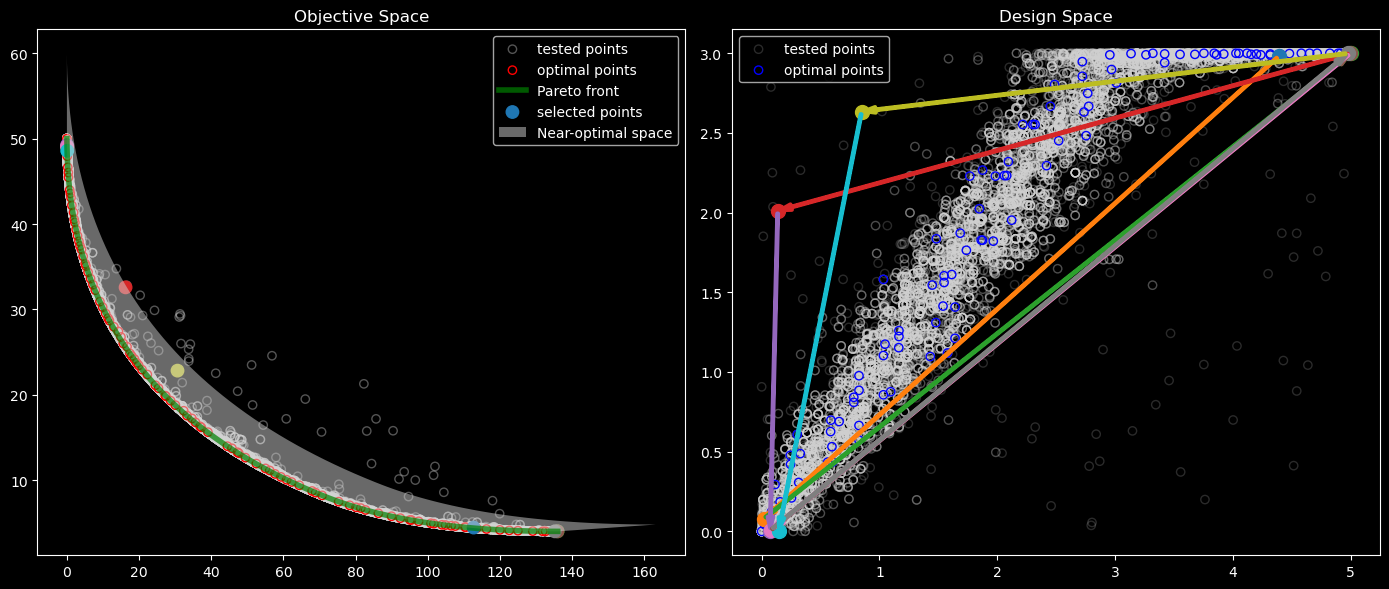

In [264]:
from mycolorpy import colorlist as mcp
import matplotlib as mpl
import matplotlib.patches as patches

cmap_name = 'tab10'
color1=mcp.gen_color(cmap=cmap_name,n=n_pts)
cmap = plt.get_cmap(cmap_name, n_pts)

with plt.style.context('dark_background'):
    fig, ax = plt.subplots(1,2, figsize=(14,6))

    ax[0].set_title("Objective Space")
    ax[0].scatter(F_hist[:,0], F_hist[:,1], facecolor="none", edgecolor="lightgray", alpha=0.4,label='tested points')
    ax[0].scatter(res.F[:,0], res.F[:,1], facecolor="none", edgecolor="red", label='optimal points')
    ax[0].plot(F[:,0], F[:,1], color="g", alpha=0.7, label='Pareto front', lw=4)
    ax[0].scatter(F_select[:,0], F_select[:,1], c=color1, s=80, label='selected points')

    ax[0].fill(np.append(f1, F1[::-1]), np.append(f2, F2[::-1]), 'lightgrey', alpha=alpha, label="Near-optimal space")
    ax[0].legend()


    ax[1].set_title("Design Space")
    ax[1].scatter(X_hist[:,0], X_hist[:,1], facecolor="none", edgecolor="lightgray", alpha=0.2, label='tested points')
    ax[1].scatter(res.X[:,0], res.X[:,1], facecolor="none", edgecolor="blue", label='optimal points')
    ax[1].legend(loc='upper left')

    style = "Simple, tail_width=0.5, head_width=4, head_length=8"
    arrows = []
    prev = X_select[0]
    for i, (c, (x, y)) in enumerate(zip(color1,X_select)):
        ax[1].scatter(x, y, color=c, s=100)
        if i == 0:
            pass
        else:
            kw = dict(arrowstyle=style, color=c, linewidth=3)
            curr = (x,y)
            arrows.append(patches.FancyArrowPatch(prev, curr, **kw))
            prev = curr

    for a in arrows:
        ax[1].add_patch(a)

    plt.tight_layout()
    plt.show()

In [265]:
from osier import n_mga

In [268]:
n_mga(results_obj=res, seed=45)

,f0,f1,designs
0,4.055871,37.069516,"[0.8416681851119427, 0.552777019344223]"
1,135.986600,4.002234,"[4.999999999825324, 2.9994416306283926]"
2,0.013187,49.365822,"[0.006725622579859092, 0.057021825753338584]"
3,135.976545,4.003911,"[4.999999999999974, 2.9990225566087565]"
4,38.799677,18.187512,"[1.3395771068200863, 2.811663618453193]"
5,0.014942,49.392450,"[0.06111950673390931, 9.057026007674995e-06]"
6,135.936160,4.002435,"[4.998768744680394, 2.999391792393302]"
7,0.014977,49.340950,"[0.005320225476190488, 0.06095919131576921]"
8,135.932589,4.003030,"[4.998768744680394, 2.9992429379992984]"
9,3.290581,41.746949,"[0.0005718740867244332, 0.9069977178955193]"


In [269]:
n_mga(results_obj=res, seed=45, wide_form=True)

,f0,f1,x0,x1
0,4.055871,37.069516,0.841668,0.552777
1,135.986600,4.002234,5.000000,2.999442
2,0.013187,49.365822,0.006726,0.057022
3,135.976545,4.003911,5.000000,2.999023
4,38.799677,18.187512,1.339577,2.811664
5,0.014942,49.392450,0.061120,0.000009
6,135.936160,4.002435,4.998769,2.999392
7,0.014977,49.340950,0.005320,0.060959
8,135.932589,4.003030,4.998769,2.999243
9,3.290581,41.746949,0.000572,0.906998


In [310]:
x = np.arange(3)
grid = np.array(list(it.product(x,x)))
pf = np.array([[0,0]])
N = 17
sf = np.c_[np.linspace(2,0,N), np.linspace(0,2,N)]
test_points = np.array([[0.5,0.5], [1.5,1.5]])

In [311]:
int_idx = check_if_interior(test_points, pf, sf)
int_pts = test_points[int_idx]
np.all(int_idx == [0])

True

In [312]:
rng = np.random.default_rng(seed=1234)
new_pts = rng.uniform(low=0, high=2, size=(10,2))
new_pts

array([[1.95339953, 0.76039147],
       [1.84649247, 0.52338485],
       [0.63819412, 0.23618247],
       [0.48353259, 0.63706786],
       [1.92815849, 0.52729961],
       [0.88201224, 1.21974162],
       [1.72724259, 1.72751534],
       [1.34976263, 1.3197487 ],
       [1.4715154 , 0.44550732],
       [0.34413237, 1.74082994]])

In [313]:
int_idx = check_if_interior(new_pts, pf, sf)

In [314]:
new_int = new_pts[int_idx]

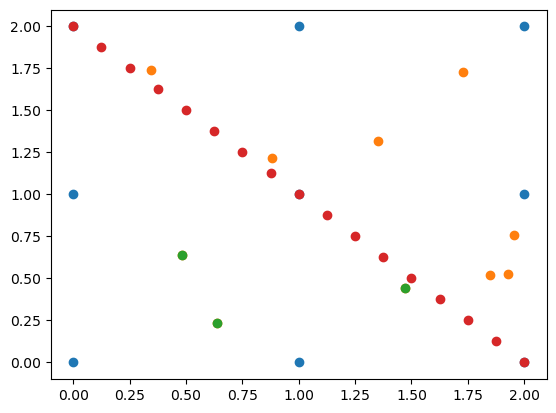

In [315]:
plt.scatter(grid[:,0],grid[:,1])
plt.scatter(new_pts[:,0],new_pts[:,1])
plt.scatter(new_int[:,0],new_int[:,1])
plt.scatter(sf[:,0],sf[:,1])
plt.show()

# 3-Dimensional MGA 

In [359]:
plane_triangle = np.array([[0,0,1], [1,0,0], [0,1,0]])
# plane_triangle = np.array([[0,0,1], [1,0,0], [0,1,0], [1,1,1]])
# plane_triangle = np.array([[0,0,1], [1,0,0], [0,1,0], [1,1,1]])

In [ ]:
X, Y = np.me

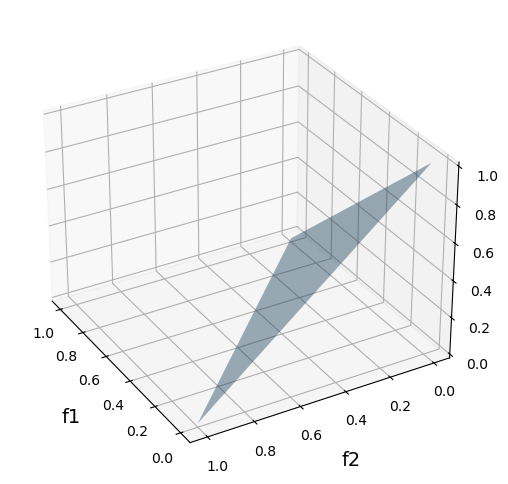

In [360]:
import matplotlib as mpl



fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(projection="3d")
ax.plot_trisurf(*zip(*plane_triangle), alpha=0.4)
# ax.scatter3D(*zip(*plane_triangle), facecolor='tab:red')
# ax.scatter3D(*([np.sqrt(2)/2,np.sqrt(2)/2,np.sqrt(2)/2]), color='blue')
# ax.plot_trisurf(*zip(*pf_slack),color='tab:green', alpha=0.2)
# ax.view_init(45, 45)
ax.view_init(30, 150)

ax.set_xlabel('f1', fontsize=14, labelpad=10)
ax.set_ylabel('f2', fontsize=14, labelpad=10)
ax.set_zlabel('f3', fontsize=14, labelpad=10)

# plt.tight_layout()
plt.show()